## Infer orbit properties from the stream

What can we learn abour the orbit from the stream properties?

First, lets look at $t_{esc}$ for each star

In [41]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py 
import json
import sys 
import astropy.coordinates as coord
import astropy.units as u
import pandas as pd 
sys.path.append("/home/sferrone/GC-tidal-loss/simulations/analytic-GC-tidal-loss/code")
import inputMW
import inputGC
sys.path.append("../src/")
import orbitCoords as OC
import trace_orbit as TO 
import orbParams as OP

In [2]:
k=0
# grab the orbits
GCnames,version,model=np.loadtxt("../little-data/clean_stream.txt",delimiter=',',dtype=str,unpack=True)
f=open("../little-data/config.json")
C = json.load(f)
backwardpath,forwardpath=TO.orbitpath(C)
streampath=TO.get_streampath(version=version[k],model=model[k])
yprimes=pd.read_csv("../little-data/gc_yprimes.csv",sep=",")
plt.style.use('dark_background')

EDR3 PII


In [3]:
# get the omega and oemga dot for all GCnames
omegas,omegaNorms=[],[]
omegaDots=[]
Ws =[]
for k in range(len(GCnames)):
    print(GCnames[k])
    t,W=TO.load_orbit(backwardpath,forwardpath,GCnames[k],C)
    omega,omegamag,omegaDotMag=OP.getOmegaDot(t,W)
    omegas.append(omega)
    omegaNorms.append(omegamag)
    omegaDots.append(omegaDotMag)
    Ws.append(W)

AM4
Arp2
Crater
E3
Eridanus
IC4499
NGC3201
NGC4590
NGC5024
NGC5053
NGC5272
NGC5466
NGC6101
NGC6934
Pal1
Pal3
Pal5
Pal12
Pal13
Pal14
Pyxis
Rup106
SagittariusII
Ter7
Ter8
Whiting1


get the stream data

In [135]:
k=np.where(GCnames=="Crater")[0][0]

In [143]:
gcname=GCnames[k]
dt = 0.3
# get the data in the reference frame of the stream
stream=h5py.File(streampath+GCnames[k]+".h5")
COM = OC.getCOM(GCnames[k])
mass,radius=inputGC.Plummer(GCnames[k]) 
# load ORBIT
t,W=TO.load_orbit(backwardpath,forwardpath,GCnames[k],C)
# filter the orbit by time 
cond = np.abs(t) < dt
ts,Ws = t[cond],W[cond,:]
past,future=(ts < 0),(ts > 0)
x,y,z = Ws[:,0],Ws[:,1],Ws[:,2]
vx,vy,vz = Ws[:,3],Ws[:,4],Ws[:,5]
# store the center of mass
xcom,ycom,zcom=COM.x.value,COM.y.value,COM.z.value
# Get stream positions
Xp,Yp,Zp=np.array(stream['galactocentric']['X']),np.array(stream['galactocentric']['Y']),np.array(stream['galactocentric']['Z'])
VXp,VYp,VZp=np.array(stream['galactocentric']['VX']),np.array(stream['galactocentric']['VY']),np.array(stream['galactocentric']['VZ'])
# initialize arrays for stream in orbit frame
xprime,indexes,tt=np.zeros(Xp.shape),np.zeros(Xp.shape),np.zeros(Xp.shape)
orbCoords,velCoords=np.zeros((Xp.shape[0],3)),np.zeros((Xp.shape[0],3))
# initialize array for orbit in orbit frame
xprimeORB=np.zeros(x.shape)
tt=np.zeros(Xp.shape)
# compute distaince along the orbit 
xprimeORB=OC.define_orbital_coordinate(x, y, z, xcom, ycom, zcom, xprimeORB)
tt,xprime,orbCoords,indexes,velCoords = OC.getorbcoords(Xp,Yp,Zp,VXp,VYp,VZp, ts,x,y,z,vx,vy,vz, xprimeORB,tt, xprime,orbCoords,velCoords,indexes)
cond0 = stream['energy']['Tescape'][:]>0
cond1,cond2  = xprime < 0,xprime > 0
cond1 = np.logical_and(cond0,cond1)
cond2 = np.logical_and(cond0,cond2)

In [198]:
def scatterPlotWithColor(gcname,x,y,c1,c2,cond1,cond2,clabel,cmap="rainbow",xlabel="x' (kpc)",ylabel="y' (kpc)",):
    """
    Plot a scatter plot with colorbar

    Parameters
    ----------
    gcname : str
        name of the GC
    x : array
        x values
    y : array
        y values
    c : array
        color values
    cond1 : array   
        condition for the first scatter plot
    cond2 : array
        condition for the second scatter plot
    clabel : str
        label for the colorbar
    cmap : str
        colormap
    xlabel : str
        label for the x axis
    ylabel : str
        label for the y axis
    """
    fig,ax=plt.subplots(figsize=(15,5))
    ax.scatter(x[cond1],y[cond1],c=c1,s=1,cmap=cmap)
    im=ax.scatter(x[cond2],y[cond2],c=c2,s=1,cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    # add a colorbar that has the same size as the plot
    cbar = fig.colorbar(im, cax=cax,)
    ax.set_title(gcname)
    ax.set_xlabel(xlabel,fontsize=20)
    ax.set_ylabel(ylabel,fontsize=20)
    # make the colorbar flush with the plot
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel(clabel, rotation=270,fontsize=20)
    # set equal axis
    ax.grid(True,linestyle='--',alpha=0.2)
    # ax.set_aspect('equal')
    fig.tight_layout()
    return fig,ax

(<Figure size 1080x360 with 2 Axes>,
 <Axes: title={'center': 'Crater'}, xlabel="x' (kpc)", ylabel="y' (kpc)">)

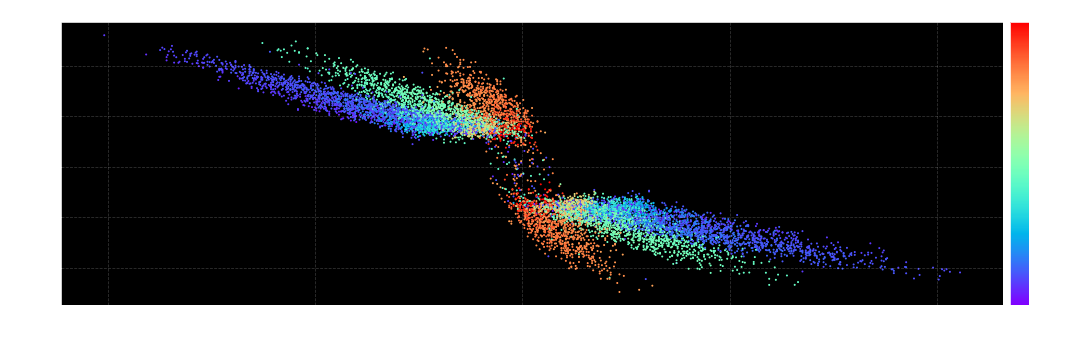

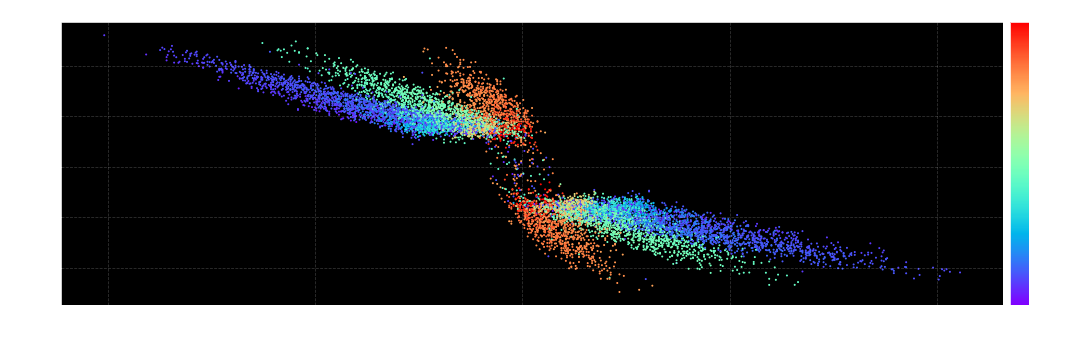

In [137]:
# color based on t-esc
fig,ax=plt.subplots(figsize=(15,5))
mytimes1=(stream['energy']['Tescape'][cond1]-50)/10
mytimes2=(stream['energy']['Tescape'][cond2]-50)/10
ax.scatter(xprime[cond1],orbCoords[cond1,0],c=mytimes1,s=1,cmap='rainbow')
im=ax.scatter(xprime[cond2],orbCoords[cond2,0],c=mytimes2,s=1,cmap='rainbow')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
# add a colorbar that has the same size as the plot
cbar = fig.colorbar(im, cax=cax,)
ax.set_title(gcname)
ax.set_xlabel("x' (kpc)",fontsize=20)
ax.set_ylabel("y' (kpc)",fontsize=20)
# make the colorbar flush with the plot
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('T$_{esc}$ (Gyrs ago)', rotation=270,fontsize=20)
# set equal axis
ax.grid(True,linestyle='--',alpha=0.2)
# ax.set_aspect('equal')
fig.tight_layout()


In [174]:
t[100000//2-10:100000//2+10]

array([-0.001 , -0.0009, -0.0008, -0.0007, -0.0006, -0.0005, -0.0004,
       -0.0003, -0.0002, -0.0001,  0.    ,  0.0001,  0.0002,  0.0003,
        0.0004,  0.0005,  0.0006,  0.0007,  0.0008,  0.0009])

In [168]:
plt.scatter(np.array(streamOmegaDots)[cond1],t[cond1],s=1)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 100001 but corresponding boolean dimension is 100000

In [186]:
mytimes=stream['energy']['Tescape'][:]/10 - 5
streamOmegaDots=[]
streamOmegas=[]
tescapes=[]
omegaMag=np.linalg.norm(omegas[k],axis=1)
for i in range(len(mytimes)):
    # find the closest time in the orbit
    index=np.argmin(np.abs(t-mytimes[i]))
    # find the omega dot at that time
    streamOmegaDots.append(omegaDots[k][index])
    streamOmegas.append(omegaMag[index])
    tescapes.append(mytimes[i])

In [197]:
mytimes1=stream['energy']['Tescape'][cond1]/10 - 5
mytimes2=stream['energy']['Tescape'][cond2]/10 - 5
tindex1 = np.array([np.argmin(np.abs(t-ti)) for ti in mytimes1])
tindex2 = np.array([np.argmin(np.abs(t-ti)) for ti in mytimes2])
omegamag1,omegamag2=omegamag[tindex1],omegamag[tindex2]
omegaDotMag1,omegaDotMag2=omegaDotMag[tindex1],omegaDotMag[tindex2]

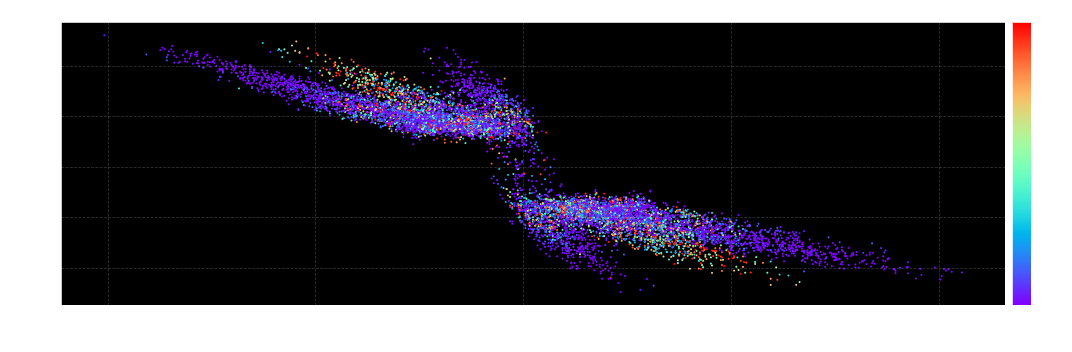

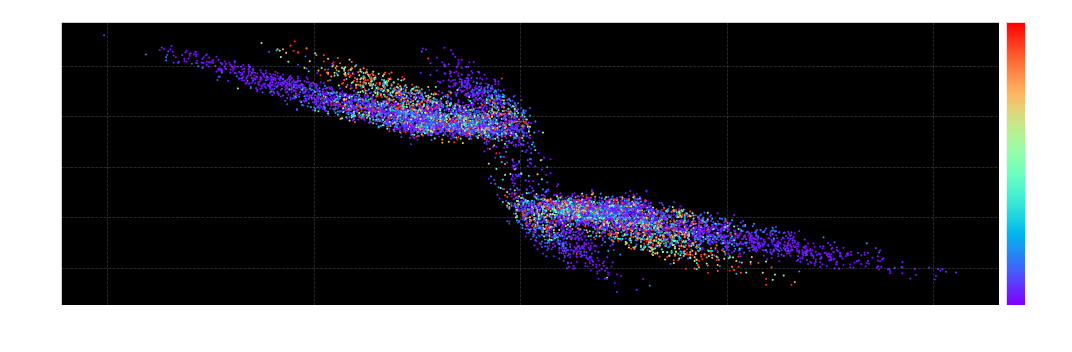

In [202]:
fig,_=scatterPlotWithColor(GCnames[k],xprime,orbCoords[:,0],omegamag1,omegamag2,cond1,cond2,clabel='$|\omega|$@ escape')
fig,_=scatterPlotWithColor(GCnames[k],xprime,orbCoords[:,0],np.abs(omegaDotMag1),np.abs(omegaDotMag2),cond1,cond2,clabel='$|\omega|$@ escape')